# Gesture Recognizer

Lots of code in this notebook is modified from https://github.com/jonfroehlich/CSE590Sp2018, including the initialization, the visualization and feature-based recognizer (SVM).

Other references:

3D plot: https://stackoverflow.com/questions/1985856/how-to-make-a-3d-scatter-plot-in-python

Filter low passing signals: https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy

## 1. Initialization
### 1.1. Define SensorData & Trial

In [1]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
from scipy import signal 

import warnings
warnings.filterwarnings('ignore')

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampNano, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampNano = sensorTimestampNano.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        # xSquared = np.multiply(self.x , self.x)
        # ySquared = np.multiply(self.y, self.y)
        # zSquared = np.multiply(self.z, self.z)
        # self.mag = np.sqrt(np.add(xSquared, ySquared, zSquared))
        # Fixed April 26, 2018 based on class comment by Krzysztof D.
        self.mag = np.sqrt(self.x**2 + self.y**2 + self.z**2)
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Pads the end of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    def pad_with_zeros(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)

# A trial is one gesture recording and includes an accel SensorData object and a gyro SensorData object
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath, gyroLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.gyroLogFilenameWithPath = gyroLogFilenameWithPath
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData[1:])
        
        parsedGyroLogData = np.genfromtxt(gyroLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        self.gyro = SensorData("Gyroscope", *parsedGyroLogData[1:])
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))

### 1.2. Handle Files

In [2]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        sensorName = filenameParts[1]
        timeMs = int(filenameParts[2])
        
        # print("gestureName={} sensorName={} timeMs={}".format(gestureName, sensorName, timeMs))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gyroFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Gyroscope"])
            
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath, gyroFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Some basic preprocessing
    # Resize arrays so everything is same length (necessary for shape matching) 
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Resizing all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            trial.accel.pad_with_zeros(maxArrayLength)
            trial.gyro.pad_with_zeros(maxArrayLength)
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

# returns the total number of trials
def get_total_num_of_trials (mapGestureToTrials):
    numTrials = 0 
    for gestureName, trialSet in mapGestureToTrials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

### 1.3. Load Data

In [3]:
# Load the data

# jonLogPath = '/Users/polarischen/University/Fall/Human AI Interaction/assignment2/GestureRecognizer/data_jon'
jonLogPath = './data_jon'
jonData = parse_and_create_gesture_trials(jonLogPath)

myLogPath = './data_me'
myData = parse_and_create_gesture_trials(myLogPath)

Found 100 csv files in ./data_jon
Found 10 gestures
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Midair Clockwise O'
Found 5 trials for 'At Rest'
Found 5 trials for 'Midair Zorro Z'
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'Midair S'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Max trial length across all gesture is 'At Rest' Trial 3 with 323 sensor events. Resizing all arrays to match
Found 110 csv files in ./data_me
Found 11 gestures
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'Midair S'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Midair Clockwise O'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Your Custom Gesture'
Found 5 trials for 'At Rest'
Found 5 trials for 'Midair Zorro Z'
Max trial length across all 

## 2. Visualization
### 2.1. Define Visualizer

In [4]:
import itertools
import statistics as stats
from mpl_toolkits.mplot3d import Axes3D
import random 

class Visualizer:
    def __init__(self, data):
        self.data = data
        
    # Plot signals
    def plotSignals(self):
        fig, axes = plt.subplots(len(self.data), 8, figsize=(20, 3 * len(self.data)))
        fig.subplots_adjust(hspace=0.5)

        index = 0
        gestureNamesSorted = sorted(self.data.keys())
        for gestureName in gestureNamesSorted:
            gestureTrials = self.data[gestureName]

            trialNum = 1
            for trial in gestureTrials:
                axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
                axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
                axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
                axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
                axes[index][4].plot(trial.gyro.x, alpha=0.7, label="Trial {}".format(trialNum))
                axes[index][5].plot(trial.gyro.y, alpha=0.7, label="Trial {}".format(trialNum))
                axes[index][6].plot(trial.gyro.z, alpha=0.7, label="Trial {}".format(trialNum))
                axes[index][7].plot(trial.gyro.mag, alpha=0.7, label="Trial {}".format(trialNum))
                trialNum = trialNum + 1

            axes[index][0].set(xlabel='Time', ylabel="Accel (m/s^2)", title=gestureName + " (Accel X)")    
            axes[index][0].legend()
            axes[index][1].set(xlabel='Time', ylabel="Accel (m/s^2)", title=gestureName + " (Accel Y)")
            axes[index][1].legend()
            axes[index][2].set(xlabel='Time', ylabel="Accel (m/s^2)", title=gestureName + " (Accel Z)")
            axes[index][2].legend()
            axes[index][3].set(xlabel='Time', ylabel="Accel (m/s^2)", title=gestureName + " (Accel Mag)")
            axes[index][3].legend()
            axes[index][4].set(xlabel='Time', ylabel="Gyro (rad/s)", title=gestureName + " (Gyro X)")
            axes[index][4].legend()
            axes[index][5].set(xlabel='Time', ylabel="Gyro (rad/s)", title=gestureName + " (Gyro Y)")
            axes[index][5].legend()
            axes[index][6].set(xlabel='Time', ylabel="Gyro (rad/s)", title=gestureName + " (Gyro Z)")
            axes[index][6].legend()
            axes[index][7].set(xlabel='Time', ylabel="Gyro (rad/s)", title=gestureName + " (Gyro Mag)")
            axes[index][7].legend()

            index += 1
    
    # Analyze frequency
    def analyzeFrequency(self):
        samplingRateInSecs = 50 # 50Hz for Android sensor
        NFFTtestVal = 64 # Use in NFFT
        signalTypes = 2 # Accel, Gyro
        typesOfGraphs = 3 # Mag, Spectral Analysis & Spectogram 

        fig, axes = plt.subplots(len(self.data), signalTypes * typesOfGraphs, figsize=(5 * signalTypes * typesOfGraphs, 10 * len(self.data)))
        fig.subplots_adjust(hspace=0.5)

        index = 0
        gestureNamesSorted = sorted(self.data.keys())
        for gestureName in gestureNamesSorted:
            gestureTrials = self.data[gestureName]

            # Analyze first trial
            trial = gestureTrials[0]

            # Accel
            # 1. Mag
            axes[index][0].plot(trial.accel.mag, alpha=0.7, label="Trial 1")   
            axes[index][0].set(xlabel='Time', ylabel="Accel (m/s^2)", title = gestureName + " (Accel Mag)")
            axes[index][0].legend()

            # 2. Spectral analysis
            powerSpectrum, powerFreq = axes[index][1].psd(trial.accel.mag, NFFT=NFFTtestVal, Fs=samplingRateInSecs, label="Trial 1")
            axes[index][1].set(xlabel='Time', ylabel="Frequency (Spectral Energy)", title="Spectral Analysis Accel ({})".format(gestureName))
            axes[index][1].legend()

            # 3. Spectogram
            axes[index][2].specgram(trial.accel.mag, NFFT=NFFTtestVal, Fs=samplingRateInSecs, noverlap=0)
            axes[index][2].set(xlabel='Time', ylabel="Frequency (Spectral Energy)", title='FFT of Accel ({})'.format(gestureName))

            # Gyro
            # 1. Mag
            axes[index][3].plot(trial.gyro.mag, alpha=0.7, label="Trial 1")   
            axes[index][3].set(xlabel='Time', ylabel="Accel (rad/s)", title = gestureName + " (Gyro Mag)")
            axes[index][3].legend()

            # 2. Spectral analysis
            powerSpectrum, powerFreq = axes[index][4].psd(trial.gyro.mag, NFFT=NFFTtestVal, Fs=samplingRateInSecs, label="Trial 1")
            axes[index][4].set(xlabel='Time', ylabel="Frequency (Spectral Energy)", title="Spectral Analysis Gyro ({})".format(gestureName))
            axes[index][4].legend()
            
            # 3. Spectogram
            axes[index][5].specgram(trial.gyro.mag, NFFT=NFFTtestVal, Fs=samplingRateInSecs, noverlap=0)
            axes[index][5].set(xlabel='Time', ylabel="Frequency (Spectral Energy)", title='FFT Of Gyro ({})'.format(gestureName))

            index += 1
            
    # Explore features
    def exploreFeatures(self):
        mapMarkerToDesc = {
            ".":"point",
            ",":"pixel",
            "o":"circle",
            "v":"triangle_down",
            "^":"triangle_up",
            "<":"triangle_left",
            ">":"triangle_right",
            "1":"tri_down",
            "2":"tri_up",
            "3":"tri_left",
            "4":"tri_right",
            "8":"octagon",
            "s":"square",
            "p":"pentagon",
            "*":"star",
            "h":"hexagon1",
            "H":"hexagon2",
            "+":"plus",
            "D":"diamond",
            "d":"thin_diamond",
            "|":"vline",
            "_":"hline"
        }

        # 1D Plot 1
        markers = list(mapMarkerToDesc.keys())
        marker = itertools.cycle(markers)
        plt.figure(figsize=(12, 6))
        for gestureName, trials in self.data.items():
            x = list(trial.gyro.z.min() for trial in trials)
            y = np.random.rand(len(x))
            s = [200] * len(x)
            plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

        plt.ylim((0,10))
        plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
        plt.title("1D Plot of gyro.z.min")
        plt.show()

        # 1D Plot 2
        markers = list(mapMarkerToDesc.keys())
        marker = itertools.cycle(markers)
        plt.figure(figsize=(12, 6))
        for gestureName, trials in self.data.items():
            x = list(stats.stdev(trial.accel.mag) for trial in trials)
            y = np.random.rand(len(x))
            s = [200] * len(x)
            plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

        plt.ylim((0,10))
        plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
        plt.title("1D Plot of accel.mag.stdev")
        plt.show()

        # 2D Plot
        markers = list(mapMarkerToDesc.keys())
        marker = itertools.cycle(markers)
        plt.figure(figsize=(12, 6))
        for gestureName, trials in self.data.items():
            x = list(trial.gyro.z.min() for trial in trials)
            y = list(stats.stdev(trial.accel.x) for trial in trials)
            s = [200] * len(x)
            plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

        plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
        plt.title("2D Plot of gyro.z.min VS accel.mag.stdev")
        plt.show()

        # 3D Plot
        fig = plt.figure()
        ax = Axes3D(fig)
        for gestureName, trials in self.data.items():
            x = list(trial.gyro.z.min() for trial in trials)
            y = list(stats.stdev(trial.accel.x) for trial in trials)
            z = list(trial.gyro.y.max() for trial in trials)
            ax.scatter(x, y, z, label=gestureName)

        plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
        plt.title("3D Plot of gyro.z.min VS accel.mag.stdev VS gyro.y.max")
        plt.show()

jonVisualizer = Visualizer(jonData)
myVisualizer = Visualizer(myData)

### 2.2. Visualize Jon's Data
#### 2.2.1. Plot Signals

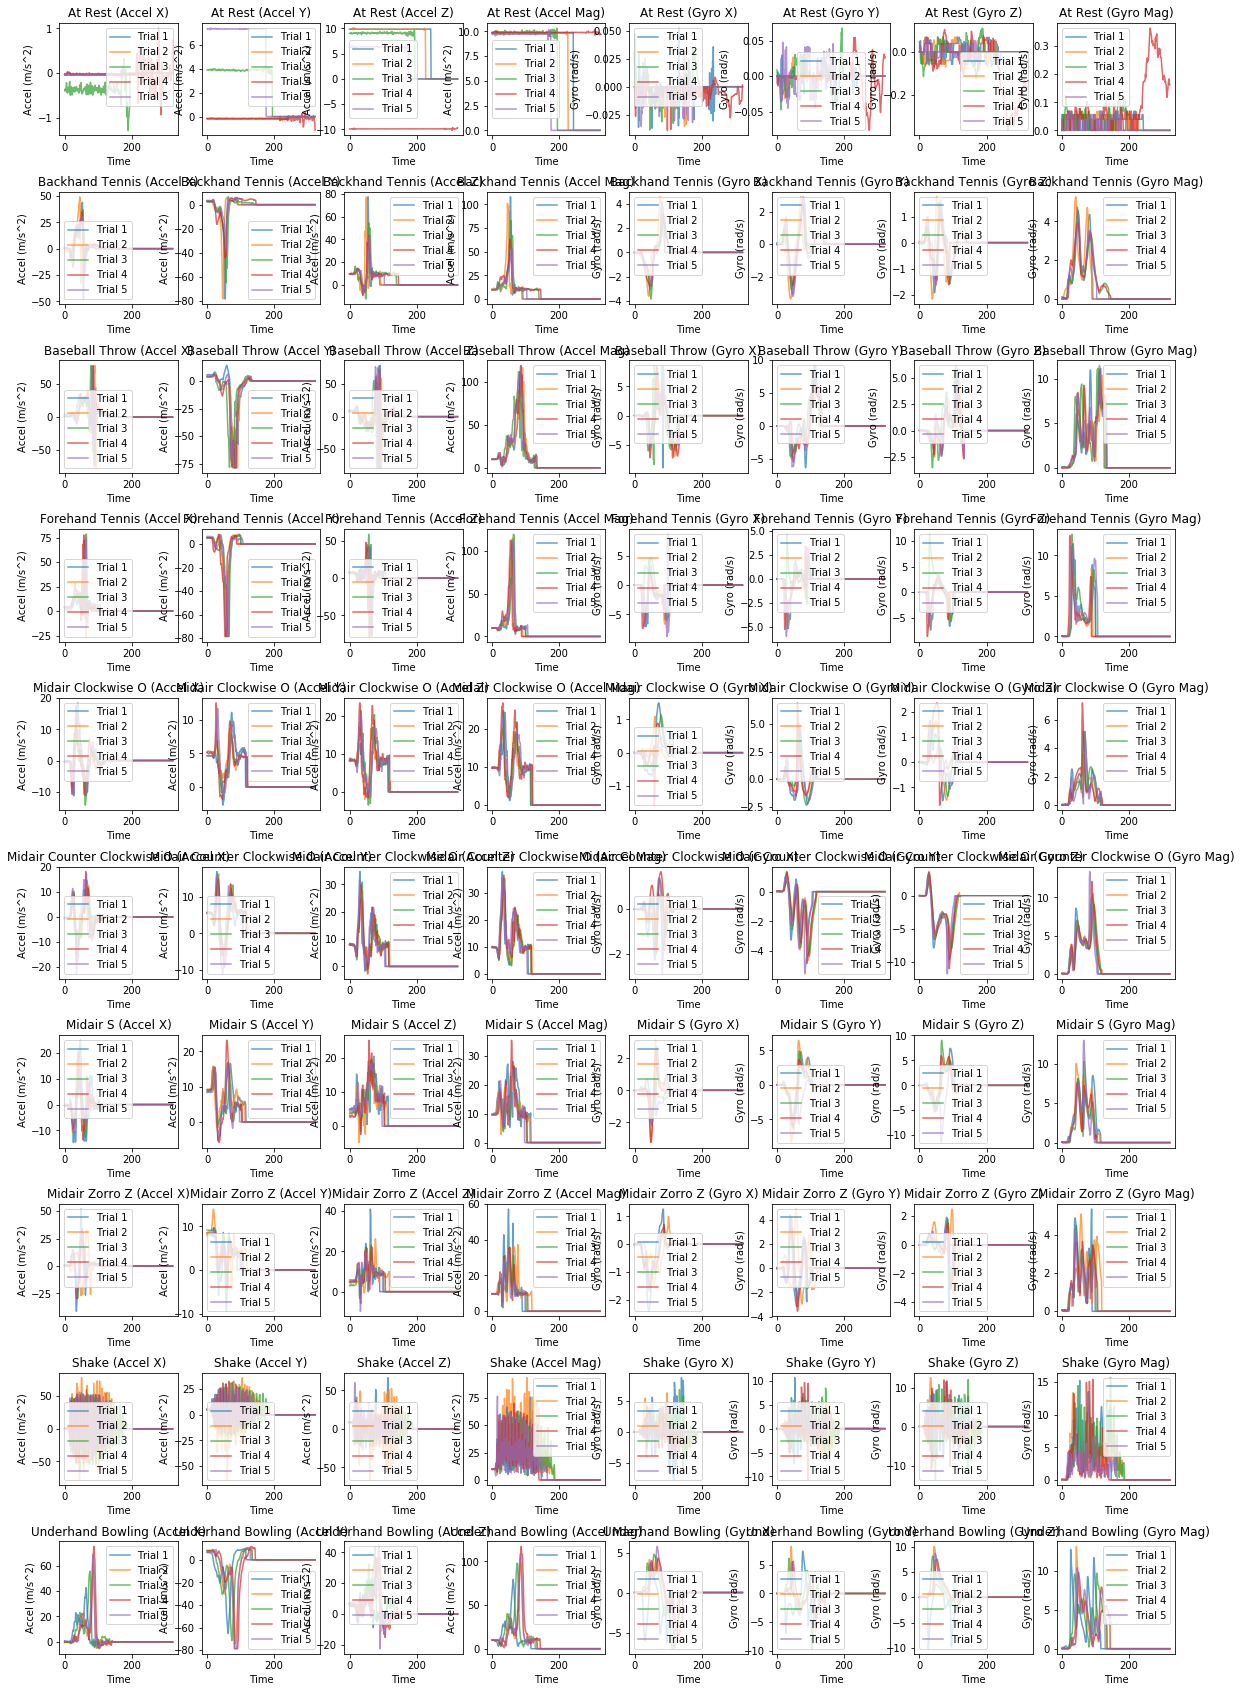

In [5]:
jonVisualizer.plotSignals()

#### 2.2.2. Analyze Frequency

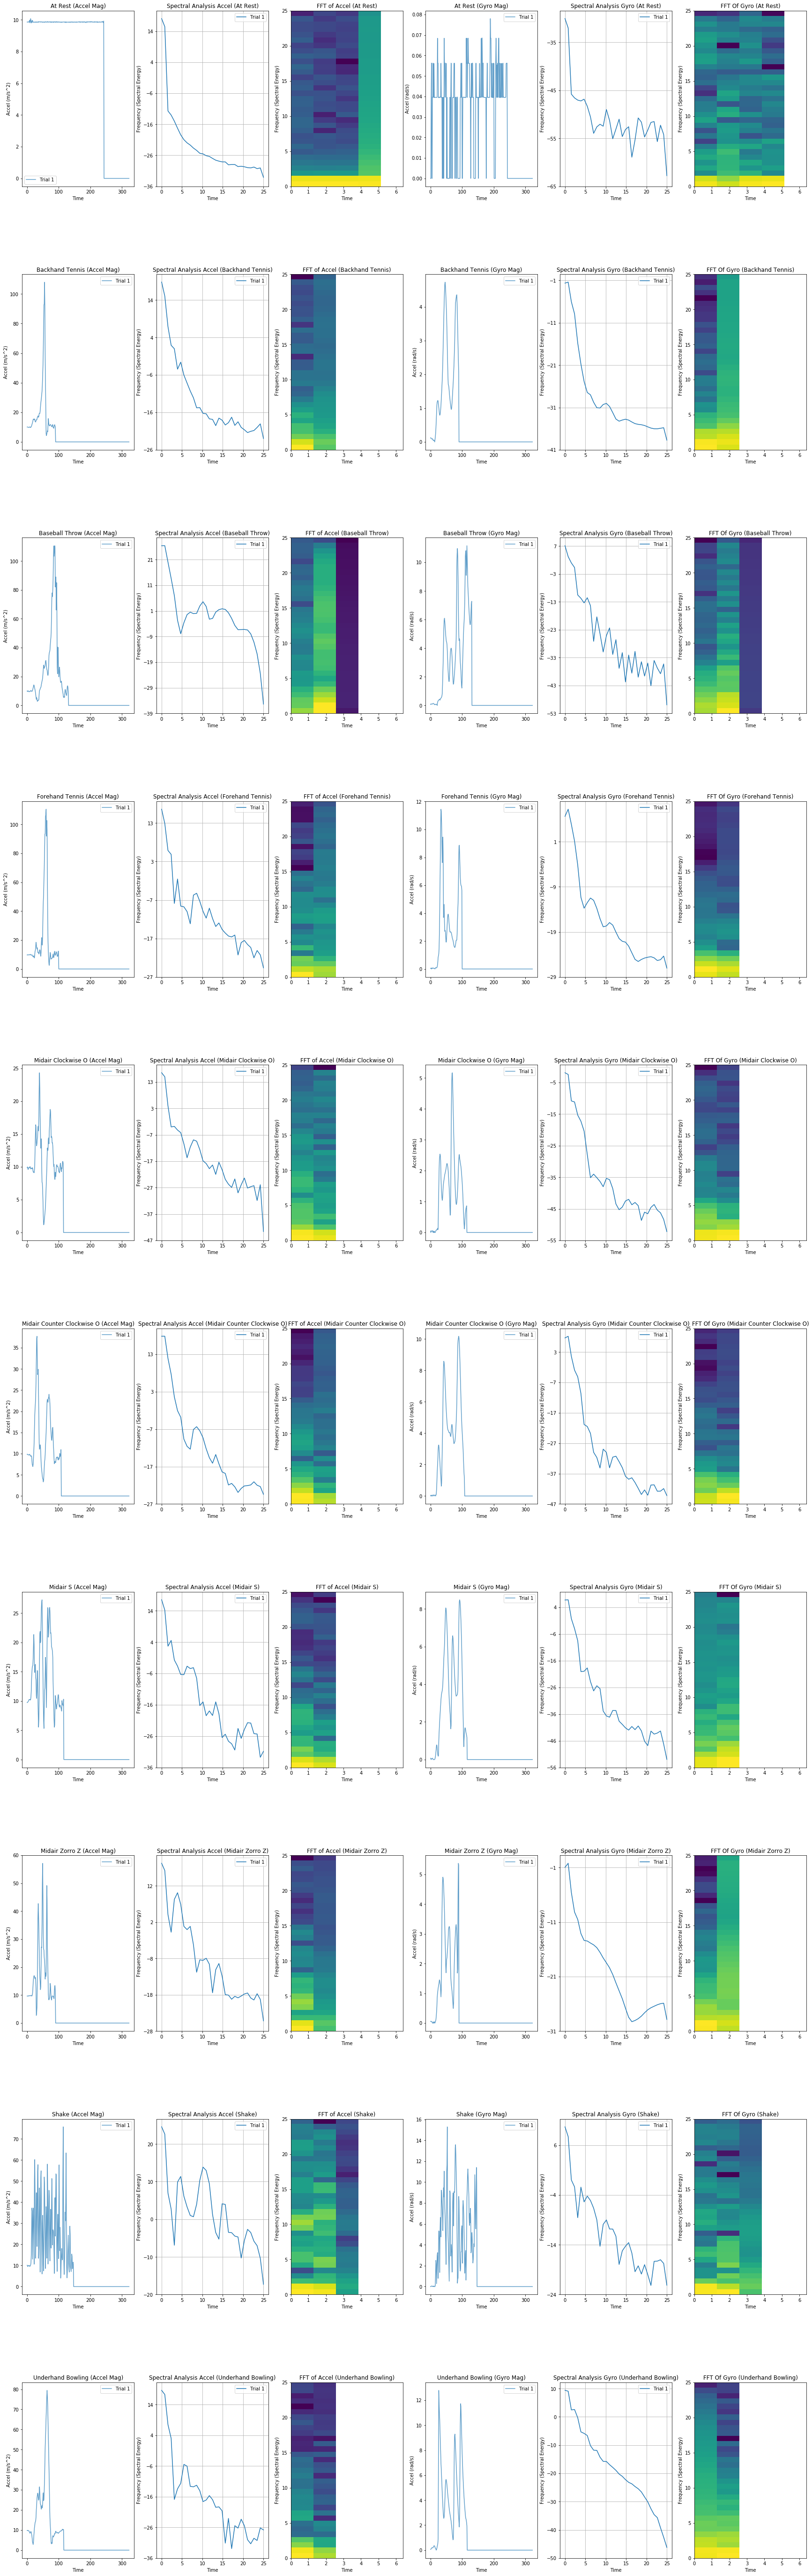

In [6]:
jonVisualizer.analyzeFrequency()

#### 2.2.3. Explore Features

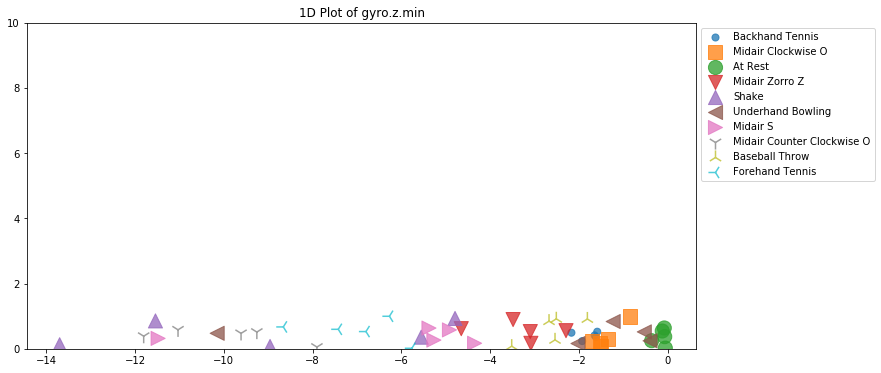

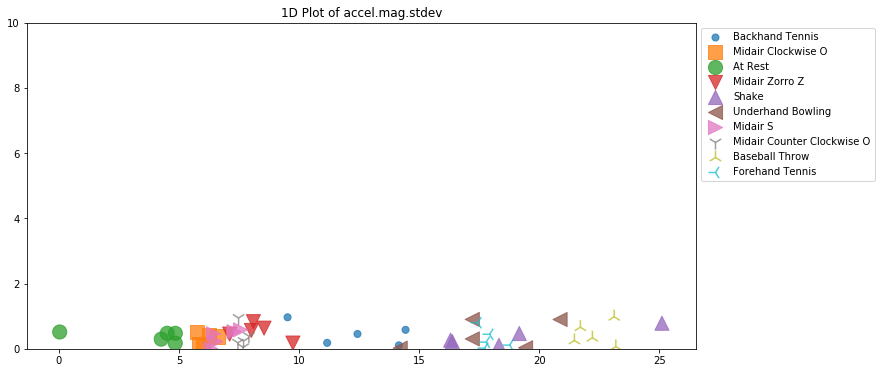

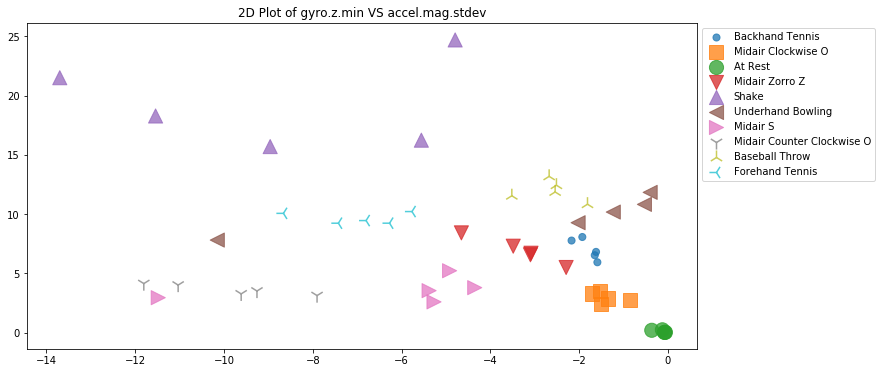

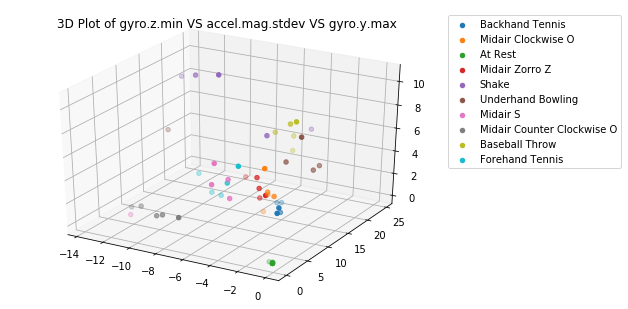

In [7]:
jonVisualizer.exploreFeatures()

### 2.3. Visualize My Data
#### 2.3.1. Plot Signals

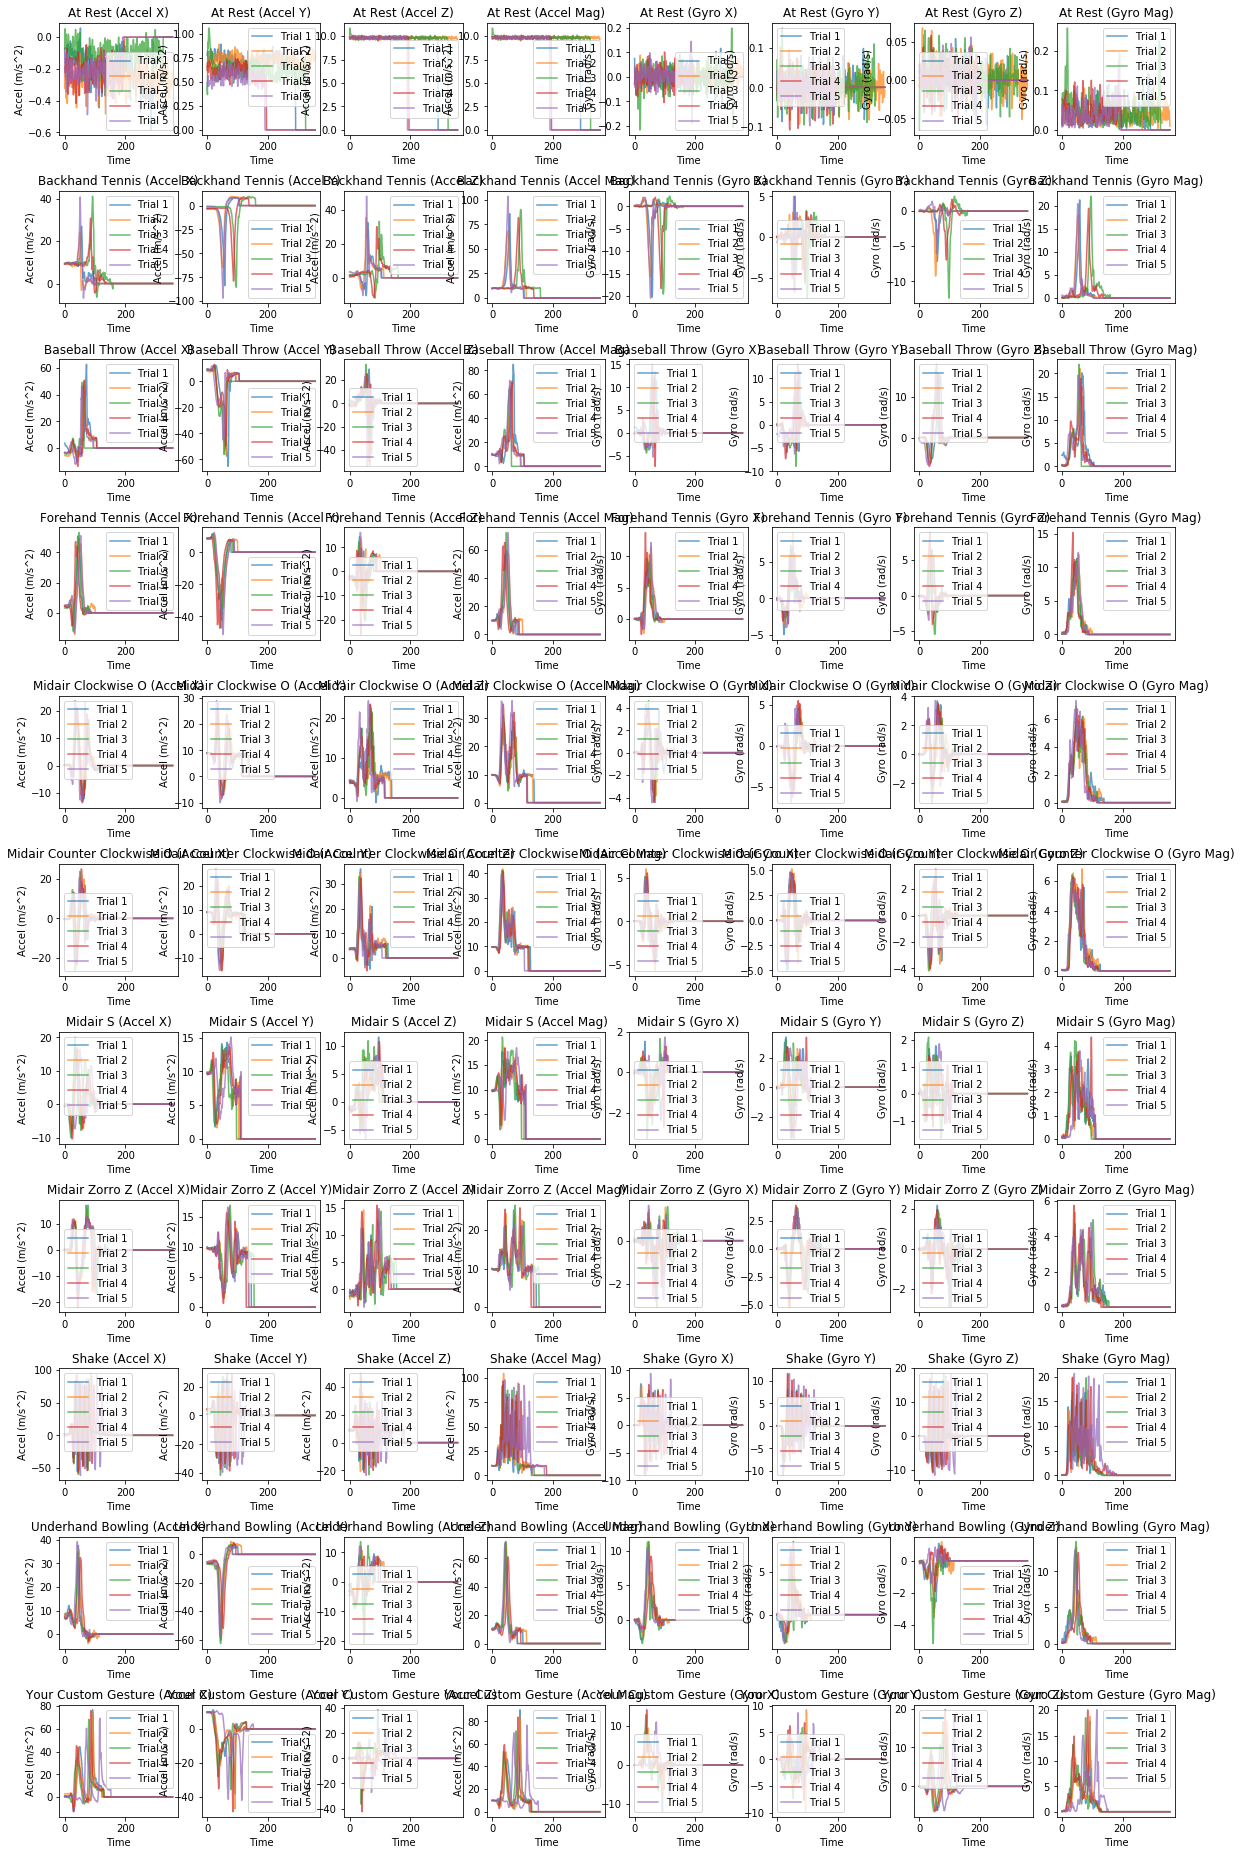

In [8]:
myVisualizer.plotSignals()

#### 2.3.2. Analyze Frequency

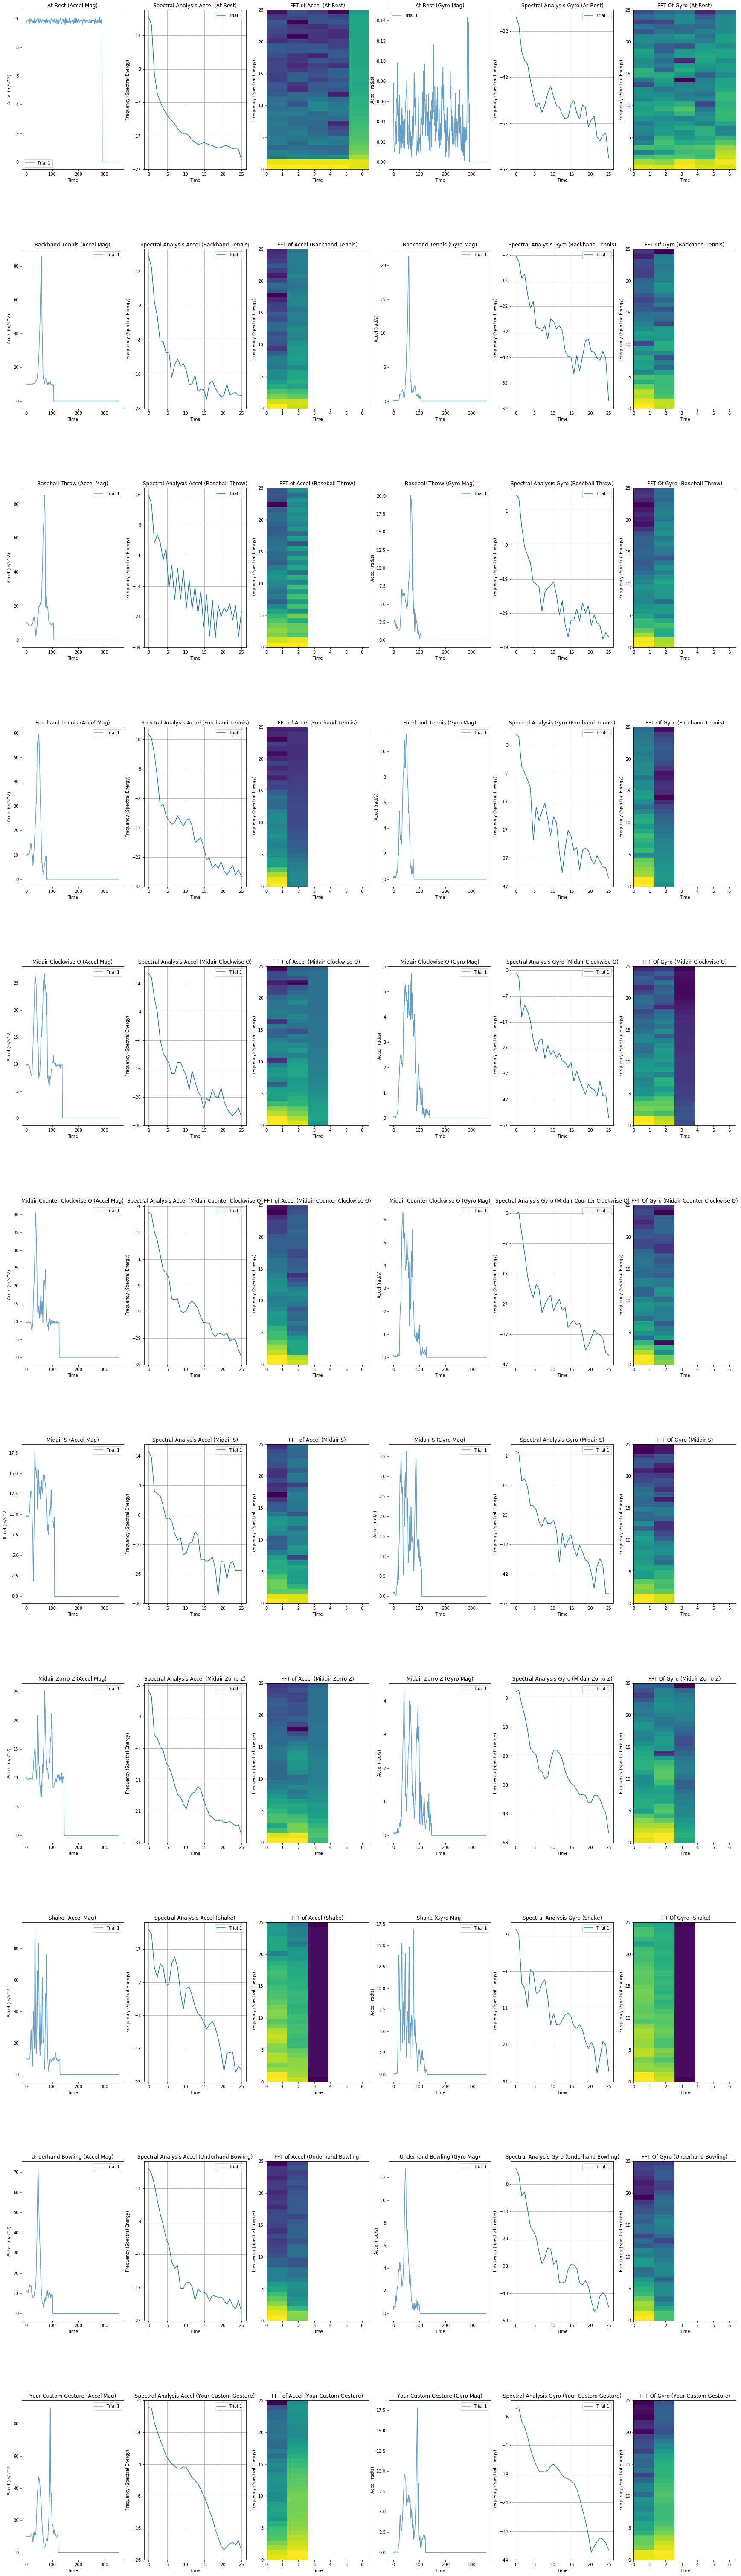

In [9]:
myVisualizer.analyzeFrequency()

#### 2.3.3. Explore Features

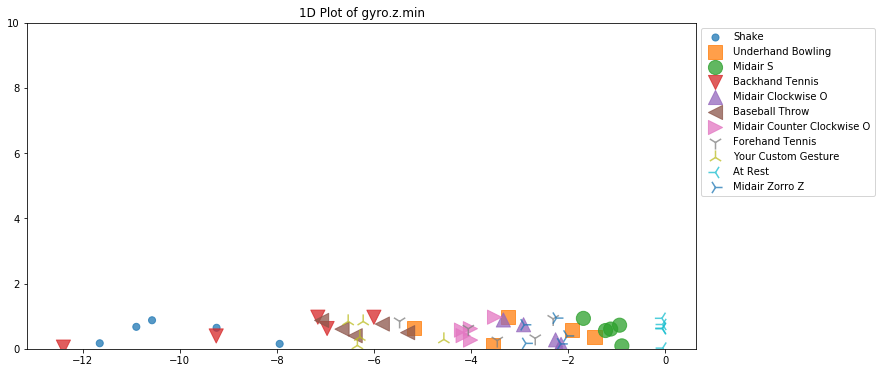

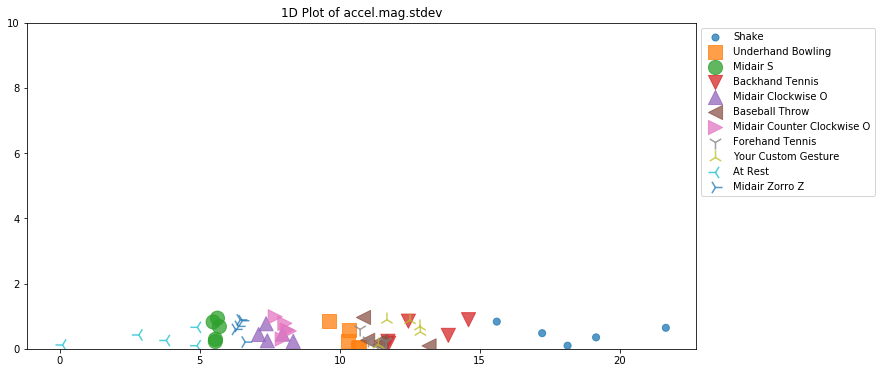

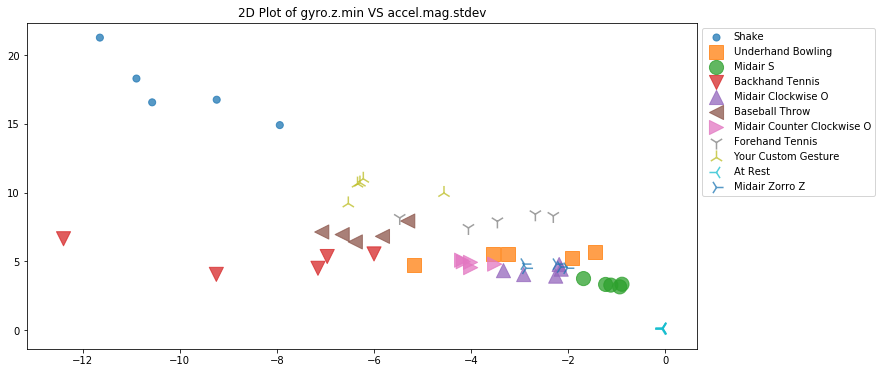

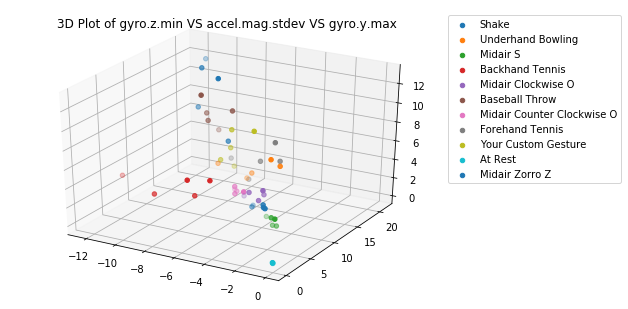

In [10]:
myVisualizer.exploreFeatures()

## 3. Implementation
### 3.1 Implement Shape-matching Recognizer

What transformations of the signal are necessary here (e.g., smoothing, detrending, etc.)?

- Filter low pass signals to smooth data
- Use correlation to align the signals before comparison
- Trim signals on both ends to remove dirty data

In [15]:
import itertools
from sklearn.metrics import confusion_matrix

"""
This function prints and plots the confusion matrix.
Normalization can be applied by setting `normalize=True`.
"""
def printConfusionMatrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("\nNormalized confusion matrix")
    else:
        print('\nConfusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def printResults(method, accuracies, groundtruth, predictions, labels):
    trialCount = len(groundtruth)//len(labels)
    totalRight = sum(accuracies.values())
    totalPossible = trialCount * len(accuracies.keys())
    
    print("{}\nOverall Accuracy: {}/{} ({::=.1%})".format(method, totalRight, totalPossible, totalRight/totalPossible))
    
    for (gesture, correctCount) in accuracies.items():
        print("{} {}/{} ({::=.1%})".format(gesture, correctCount, trialCount, correctCount/trialCount))
    
    cm = confusion_matrix(groundtruth, predictions, labels)
    plt.figure()
    printConfusionMatrix(cm, classes=labels, title="{}\nOverall Accuracy: {}/{} ({::=.1%})".format(method, totalRight, totalPossible, totalRight/totalPossible))
    plt.show()

In [31]:
from scipy.spatial import distance

class ShapeMatchingRecognizer():
    def __init__(self, data):
        # super(ShapeMatchingRecognizer, self).__init__()
        self.data = data
    
    # Filter low pass signals to smooth data
    def filterLowPassSignals(self, signal, n=3):
        ret = np.cumsum(signal, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n
    
    # Use correlation to align the signals before comparison
    def alignSignals(self, a, b):
        correlateAToB = signal.correlate(a,b)
        bestCorrelationPoint = np.argmax(correlateAToB)
        indexShift = len(a) - np.argmax(correlateAToB)
        a_shifted = np.roll(a, indexShift)
        return a_shifted
        
    # Trim signals on both ends to remove dirty data
    def trimSignals(self, signal, trimLength):
        maxAllowedTrim = len(signal) // 4
        if trimLength > maxAllowedTrim:
            trimLength = len(signal) // 4
        return signal[trimLength: len(signal) - trimLength]
        
    # Compare test and trial
    def compare(self, templateTrial, testSignal, templateSignal):
        smoothTest = self.filterLowPassSignals(testSignal)
        smoothTemplate = self.filterLowPassSignals(templateSignal)
        testTrialAligned = self.alignSignals(smoothTest, smoothTemplate)
        testVsTemplateDistance = distance.euclidean(testTrialAligned, smoothTemplate)
        return (templateTrial, testVsTemplateDistance)

    # Recognize
    def recognize(self):
        # Results
        accuracies = dict.fromkeys(self.data.keys(), 0)
        predictions = []
        truths = []
        
        # Randomly init folds
        foldCount = len(list(self.data.values())[0])
        folds = []
        for i in range(foldCount):
            folds.append([])
        labels = list(self.data.keys())
        for gesture in labels:
            trials = self.data[gesture]
            random.shuffle(trials) # Shuffle trial order first
            for i in range(len(folds)):
                folds[i].append(trials[i])
        
        # Loop folds
        for f in range(len(folds)):        
            # Loop trials in the fold
            for i in range(len(folds[f])):
                testTrial = folds[f][i]
                bestMatch = None
                secondMatch = None
                # First compare trial with folds
                for currentFold in folds:
                    if currentFold != folds[f]: # Skip current fold
                        for templateTrial in currentFold:
                            compareResults = self.compare(templateTrial, testTrial.accel.mag, templateTrial.accel.mag)
                            # Find best match
                            if bestMatch is None or compareResults[1] < bestMatch[1]:
                                bestMatch = compareResults
                            # Find second-best match
                            if secondMatch is None or (compareResults[1] < secondMatch[1] and compareResults[1] > bestMatch[1]):
                                secondMatch = compareResults
                predictionGesture = bestMatch[0].gestureName
                
                # If second-best match is within 25% of best match, trim and compare again
                if secondMatch[1] < (1.25 * bestMatch[1]):
                    trimLength = 45 # Try
                    compareResultsMost = self.compare(bestMatch[0], self.trimSignals(testTrial.gyro.y, trimLength), self.trimSignals(bestMatch[0].gyro.y, trimLength))
                    compareResultsSecond = self.compare(secondMatch[0], self.trimSignals(testTrial.gyro.y, trimLength), self.trimSignals(secondMatch[0].gyro.y, trimLength))
                    if compareResultsSecond[1] < compareResultsMost[1]:
                        predictionGesture = secondMatch[0].gestureName
                
                # Update accuracies, predictions, truths
                if testTrial.gestureName == predictionGesture :
                    accuracies[testTrial.gestureName] += 1
                predictions.append(predictionGesture)
                truths.append(testTrial.gestureName)

        printResults("Shape-matching Recognizer", accuracies, truths, predictions, labels)
        
jonShapeMatchingRecognizer = ShapeMatchingRecognizer(jonData)
myShapeMatchingRecognizer = ShapeMatchingRecognizer(myData)

### 3.2 Implement Feature-Based Recognizer

In [17]:
from sklearn import svm
import statistics as stats

class FeatureBasedRecognizer():
    def __init__(self, data):
        # super(FeatureBasedRecognizer, self).__init__()
        self.data = data

    # Returns a list of folds where each list item is a dict() with key=gesture name and value=selected trial for that fold
    # if createNewKFold is True, returns a new random fold, otherwise returns same fold setup as before 
    # (this is to better enable repeat experimentation)
    def generateKFolds(self, numFolds=5, createNewKFold=False):
        # Quick check to make sure that there are numFolds of gesture trials for each gesture
        for gestureName, trials in self.data.items():
            if numFolds != len(trials):
                raise ValueError("For the purposes of this assignment, the number of folds={} must equal the number of trials for each gesture. Gesture '{}' has {} trials"
                                 .format(numFolds, gestureName, len(trials)))


        numGestures = len(self.data)
        tmpMapGestureToTrials = dict()
        for gestureName, trials in self.data.items():
            tmpMapGestureToTrials[gestureName] = list(trials)
        
        gestureNames = list(self.data.keys())

        # Create folds
        foldToMapGestureToTrial = list()
        for i in range(0, numFolds):
            curFoldMapGestureToTrial = dict()
            foldToMapGestureToTrial.append(curFoldMapGestureToTrial)
            
            for j in range(0, numGestures):
                curGestureName = gestureNames[j]
                trialList = tmpMapGestureToTrials[curGestureName]
                randTrialIndex = 0
                if (len(trialList) > 0):
                    randTrialIndex = random.randint(0, len(trialList) - 1)

                randTrial = trialList[randTrialIndex]
                curFoldMapGestureToTrial[curGestureName] = randTrial
                del trialList[randTrialIndex]
        
        return foldToMapGestureToTrial
       
    # takes in the current testFold, the trainingFolds, and a create_feature_vector function
    # the create_feature_vector function creates feature vectors given a Trial object
    # I suggest creating multiple different create_feature_vector functions that you pass
    # in here and test (this will allow you to easily compare different feature vectors)
    def getSvmInput(self, testFold, trainingFolds, create_feature_vector):
        
        # calculate the number of training trials
        numOfTrainingTrials = 0
        for trainingFold in trainingFolds:
            numOfTrainingTrials = numOfTrainingTrials + len(trainingFold)
            
        # Now figure out the number of features from the create_feature_vector call
        # This is just a dummy call to figure out the number of features in order to
        # properly initialize our trainingData matrix
        tmpTrainingTrial = random.choice(list(trainingFolds[0].values()))
        numFeatures = len(create_feature_vector(tmpTrainingTrial))
        # print("The feature vector size is: {}".format(numFeatures))
         
        # now we can setup our training data structures  
        # each row in our trainingData matrix corresponds to a trial
        # and each column corresponds to a feature
        trainingData = np.zeros([numOfTrainingTrials, numFeatures])
        trainingTrials = list()
        trainingLabels = np.array([])
      
        # Build up the training data and also keep track of the class labels (in trainingLabels)
        row = 0
        for trainingFold in trainingFolds:
            for trainingGestureName, trainingTrial in trainingFold.items():
                trainingData[row] = create_feature_vector(trainingTrial)
                trainingLabels = np.append(trainingLabels, trainingTrial.gestureName)
                trainingTrials.append(trainingTrial)
                row = row + 1
        
        # Now setup the testData data structure
        testData = np.zeros([len(testFold), numFeatures])
        testRow = 0
        groundtruthLabels = list()
        testTrials = list()
        for testGestureName, testTrial in testFold.items():
            testTrials.append(testTrial)
            testData[testRow] = create_feature_vector(testTrial)
            groundtruthLabels.append(testGestureName)
            testRow = testRow + 1
        
        return (trainingData, trainingLabels, trainingTrials, testData, groundtruthLabels, testTrials)

    # Example create_feature_vector function that returns a 3D feature vector for the given trial        
    def createSimpleFeatureVector(self, trial):
        return [trial.gyro.y.max(), trial.gyro.z.min(), stats.stdev(trial.accel.x)]

    def recognize(self):
        # Setup variables
        numFolds = get_min_num_of_trials(self.data)
        numGestures = len(self.data)
        numTrials = get_total_num_of_trials(self.data)
        foldToMapGestureToTrial = self.generateKFolds()
        gestureNames = list(self.data.keys())
        accuracies = dict.fromkeys(self.data.keys(), 0)
        predictions = []
        truths = []

        for j in range(len(foldToMapGestureToTrial)):
            # This is an example of how you would call the self.getSvmInput method
            # You'll have to figre out how to appropriately put this in a for loop and use it...  
            testFold = foldToMapGestureToTrial[j]
            trainingFolds = foldToMapGestureToTrial[:j] + foldToMapGestureToTrial[j+1:]
            svmInput = self.getSvmInput(testFold, trainingFolds, self.createSimpleFeatureVector)

            # Unpack the tuple into more semantic variable names
            trainingData, trainingLabels, trainingTrials, testData, groundtruthLabels, testTrials = svmInput

            ## Training our SVM
            clf = svm.SVC()
            clf.fit(trainingData, trainingLabels) 

            svmPrediction = clf.predict(testData)
            for i in range(len(testData)):
                predictions.append(svmPrediction[i])
                truths.append(groundtruthLabels[i])
                if svmPrediction[i] == groundtruthLabels[i]:
                    accuracies[groundtruthLabels[i]] += 1

        printResults("Feature-based Recognizer", accuracies, truths, predictions, gestureNames)
        
jonFeatureBasedRecognizer = FeatureBasedRecognizer(jonData)
myFeatureBasedRecognizer = FeatureBasedRecognizer(myData)

## 4. Validation
### 4.1. Validate Jon's Data
Shape-matching

Jon Data

Shape-matching Recognizer
Shape-matching Recognizer
Overall Accuracy: 49/50 (98.0%)
Backhand Tennis 4/5 (80.0%)
Midair Clockwise O 5/5 (100.0%)
At Rest 5/5 (100.0%)
Midair Zorro Z 5/5 (100.0%)
Shake 5/5 (100.0%)
Underhand Bowling 5/5 (100.0%)
Midair S 5/5 (100.0%)
Midair Counter Clockwise O 5/5 (100.0%)
Baseball Throw 5/5 (100.0%)
Forehand Tennis 5/5 (100.0%)

Confusion matrix, without normalization


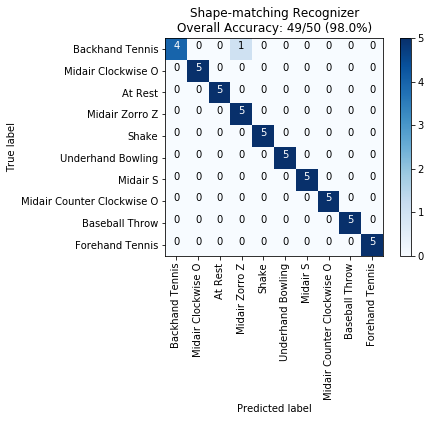


Feature-based Recognizer
Feature-based Recognizer
Overall Accuracy: 45/50 (90.0%)
Backhand Tennis 5/5 (100.0%)
Midair Clockwise O 4/5 (80.0%)
At Rest 5/5 (100.0%)
Midair Zorro Z 5/5 (100.0%)
Shake 5/5 (100.0%)
Underhand Bowling 3/5 (60.0%)
Midair S 4/5 (80.0%)
Midair Counter Clockwise O 5/5 (100.0%)
Baseball Throw 4/5 (80.0%)
Forehand Tennis 5/5 (100.0%)

Confusion matrix, without normalization


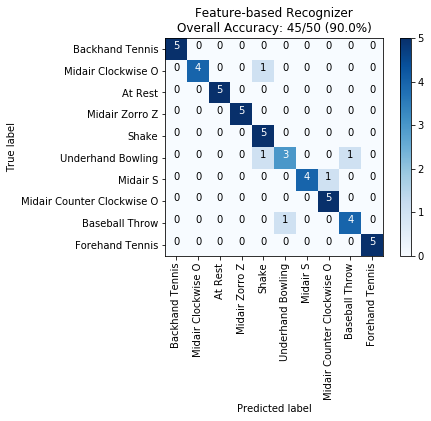

In [35]:
print("Jon Data")
print("\nShape-matching Recognizer")
jonShapeMatchingRecognizer.recognize()

print("\nFeature-based Recognizer")
jonFeatureBasedRecognizer.recognize()

### 4.2. Validate My Data

My Data

Shape-matching Recognizer
Shape-matching Recognizer
Overall Accuracy: 53/55 (96.4%)
Shake 5/5 (100.0%)
Underhand Bowling 5/5 (100.0%)
Midair S 5/5 (100.0%)
Backhand Tennis 5/5 (100.0%)
Midair Clockwise O 4/5 (80.0%)
Baseball Throw 4/5 (80.0%)
Midair Counter Clockwise O 5/5 (100.0%)
Forehand Tennis 5/5 (100.0%)
Your Custom Gesture 5/5 (100.0%)
At Rest 5/5 (100.0%)
Midair Zorro Z 5/5 (100.0%)

Confusion matrix, without normalization


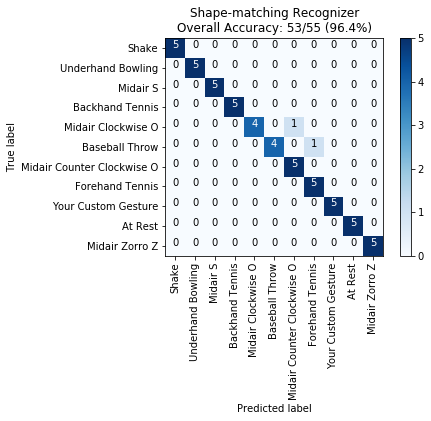


Feature-based Recognizer
Feature-based Recognizer
Overall Accuracy: 50/55 (90.9%)
Shake 5/5 (100.0%)
Underhand Bowling 4/5 (80.0%)
Midair S 5/5 (100.0%)
Backhand Tennis 3/5 (60.0%)
Midair Clockwise O 4/5 (80.0%)
Baseball Throw 5/5 (100.0%)
Midair Counter Clockwise O 5/5 (100.0%)
Forehand Tennis 4/5 (80.0%)
Your Custom Gesture 5/5 (100.0%)
At Rest 5/5 (100.0%)
Midair Zorro Z 5/5 (100.0%)

Confusion matrix, without normalization


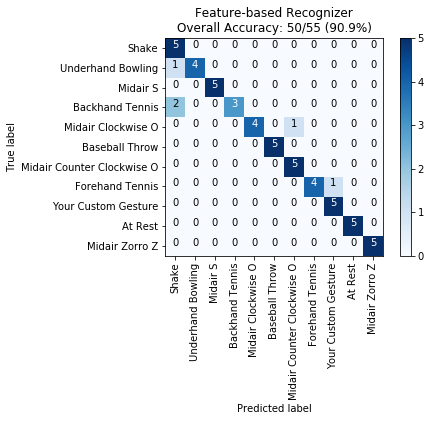

In [36]:
print("My Data")
print("\nShape-matching Recognizer")
myShapeMatchingRecognizer.recognize()

print("\nFeature-based Recognizer")
myFeatureBasedRecognizer.recognize()

## 5. Report

### 5.1. Shape-matching Recognizer
I implement the shape-matching recognizer based on euclidean distance (Jon wrote some code about euclidean distance in the sandbox part of the notebook). Before recognizing gestures, I applied some transformations of the signal:

- Filter low pass signals to smooth data
- Use correlation to align the signals before comparison
- Trim signals on both ends to remove dirty data

For overall accuracy, per-gesture accuracy, confusion matrix, please refer to **4. Validation**.

### 5.2. Feature-based Recognizer
The feature-based recognizer used the starter code about SVM found in Jon's notebook. But I changed the `create_simple_feature_vector` to return my own feature vector `[trial.gyro.y.max(), trial.gyro.z.min(), stats.stdev(trial.accel.x)]` (based on the data visualization and some experiments).

For overall accuracy, per-gesture accuracy, confusion matrix, please refer to **4. Validation**.

### 5.3. Key Challenges
- Finding an Android phone :-(
- Recording data: sometimes you would get like 7 copies of data for accel but only 4 copies gypro. Some data are missing during the record.
- Showing plot: the 3D one, not familiar with API, need help from Google and API documents.
- Reading code: it is easy to find some code about this assignment in Jon's notebook, but we need to understand how the code works. Through the reading process, I also Googled a lot as well as looked up in the API doc to understand the code. And I also learned a lot during this process.

### 5.4. What I learned
- How to find an Android phone :-)
- Explore and analyze data by visualization
- Use new APIs with help of documents and Google (to find some examples which help a lot on "using")
- How to Google efficiently and effectively.
- Know more about dtw, euclidean distance, svm, confusion matrix, k-fold through this assignment.